# R-CNN

![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/R-CNN.png)

## Clone the workshop repository from Github, clone the Tensorflow models repository, and install !pip install selectivesearch
*   Don't forget to select GPU from menus: Runtime->Change runtime type
*   To set breakpoints: from pdb import set_trace; set_trace(), and use exit() to exit
*   Hint for answer: 3A*(80C+5BD), 1x1 conv
*   Python with operator:
               class controlled_execution:
                    def __enter__(self):
                         set things up
                         return thing
                    def __exit__(self, type, value, traceback):
                         # Return true to swallow any TypeError, but lets all other exceptions through
                         return isinstance(value, TypeError)
               with controlled_execution() as thing:
                    some code

*   Padding:
"VALID" only ever drops the right-most columns (or bottom-most rows).
"SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, it will add the extra column to the right, as is the case in this example (the same logic applies vertically: there may be an extra row of zeros at the bottom).

Example:
Input width = 13
Filter width = 6
Stride = 5

    "VALID" = without padding:
       inputs:         1  2  3  4  5  6  7  8  9  10 11 12 13
                                          |_______________|                dropped
                                                                          |________________|

    "SAME" = with zero padding:
                                  pad|                                      |pad
       inputs:      0 |1  2  3  4  5  6  7  8  9  10 11 12 13|0  0
                                   |_______________|
                                                                   |_________________|
                                                                                                    |________________|

*   TF arg_scope (values that will define the defaults for each op in list_ops):
               arg_scope = tf.contrib.framework.arg_scope
               layers = tf.layers
               with arg_scope([layers.conv2d, jgjgfjy, jgjg], padding='VALID',
                   initializer=layers.variance_scaling_initializer(),
                   regularizer=layers.l2_regularizer(0.05)):
                   net = layers.conv2d(inputs, 64, [11, 11], 4, scope='conv1')
                   net = layers.conv2d(net, 256, [5, 5], scope='conv2', padding='SAME')

In [0]:
!git clone https://github.com/heshameraqi/object-detection-dl-workshop.git
!git clone https://github.com/tensorflow/models.git
!pip install selectivesearch

Cloning into 'object-detection-dl-workshop'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 157 (delta 58), reused 91 (delta 16), pack-reused 0
Receiving objects: 100% (157/157), 8.93 MiB | 24.92 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Cloning into 'models'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 28076 (delta 1), reused 2 (delta 0), pack-reused 28068
Receiving objects: 100% (28076/28076), 509.31 MiB | 38.64 MiB/s, done.
Resolving deltas: 100% (17269/17269), done.
Checking out files: 100% (3003/3003), done.
  Stored in directory: /root/.cache/pip/wheels/ab/a0/bd/a56e017d10730401fce75f62ff9364004368b0b96f12c026ba
Successfully built selectivesearch


## Download inception_resnet_v2 pretrained weights on Imagenet &  YoloV3 pretrained weights on MS-COCO

In [0]:
%cd object-detection-dl-workshop
!mkdir weights
%cd weights

!wget http://download.tensorflow.org/models/inception_resnet_v2_2016_08_30.tar.gz
!tar -xvf inception_resnet_v2_2016_08_30.tar.gz
!rm inception_resnet_v2_2016_08_30.tar.gz

# wget https://pjreddie.com/media/files/yolov3-tiny.weights 
!wget https://pjreddie.com/media/files/yolov3.weights

%cd ../..

/content/object-detection-dl-workshop
/content/object-detection-dl-workshop/weights
--2019-06-27 12:37:01--  http://download.tensorflow.org/models/inception_resnet_v2_2016_08_30.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.214.128, 2607:f8b0:4001:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.214.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220632346 (210M) [application/x-tar]
Saving to: ‘inception_resnet_v2_2016_08_30.tar.gz’

inception_resnet_v2 100%[===================>] 210.41M   172MB/s    in 1.2s    

2019-06-27 12:37:03 (172 MB/s) - ‘inception_resnet_v2_2016_08_30.tar.gz’ saved [220632346/220632346]

inception_resnet_v2_2016_08_30.ckpt
--2019-06-27 12:37:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

## Imports

In [0]:
import tensorflow as tf
tf.disable_v2_behavior()

import models.research.slim.nets.inception_resnet_v2 as incep_v2

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import selectivesearch
import matplotlib.patches as mpatches

import scipy
from PIL import Image, ImageOps
import matplotlib.patches as patches
import random

W0627 12:37:30.070175 139669244204928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/compat/v2_compat.py:61: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
W0627 12:37:32.242101 139669244204928 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0627 12:37:32.243598 139669244204928 deprecation_wrapper.py:119] From /content/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



## Configurations & Model Declarations, then create model graph on GPU

In [0]:
n_rows = 299
n_cols = 299
mscoco_names_filename = './object-detection-dl-workshop/data/coco.names'
imagenet_names_filename = './object-detection-dl-workshop/data/imagenet1000.names'

class Model_Class:
  def __init__(self, is_training):
    self.define_model(is_training)

  def define_model(self, is_training):
    self.Image = tf.placeholder(tf.float32, shape =[None, n_rows, n_cols, 3])
    with incep_v2.slim.arg_scope(incep_v2.inception_resnet_v2_arg_scope()):
        self.logits, self.end_points = incep_v2.inception_resnet_v2(self.Image, is_training = False)
        
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
with tf.device('/gpu:0'):
  model = Model_Class(is_training=...)

W0627 12:37:36.303313 139669244204928 deprecation_wrapper.py:119] From /content/models/research/slim/nets/inception_resnet_v2.py:322: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0627 12:37:45.114097 139669244204928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


## Load CNN weights

In [0]:
model.saver = tf.train.Saver()
sess=tf.Session()  # all the coming runs are in this session
model.saver.restore(sess, os.getcwd()+"/object-detection-dl-workshop/weights/inception_resnet_v2_2016_08_30.ckpt")

W0627 12:38:23.126553 139669244204928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


## Read image, preprocess it, and run the classifier

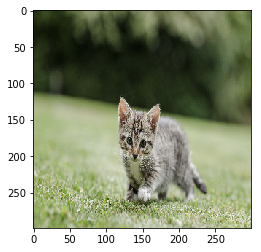

Whole image class: Siamese cat, Siamese


In [0]:
input_img_filename = './object-detection-dl-workshop/data/samples/cat.jpg'
img = cv2.imread(input_img_filename, cv2.IMREAD_COLOR)
img = img[:,:,[2,1,0]] # Make it RGB
img = cv2.resize(img, (n_rows, n_cols))
img_rgb = img.copy()
img = 2*(img/255.0)-1.0

classification = sess.run(model.end_points['Predictions'], feed_dict= {model.Image:[img]})

# print results
calss_id = np.argmax(classification)+1 # +1 because that the network has the first class as "I don't know" and it's not included in the imagenet dict
classes_dict = eval(open(imagenet_names_filename).read())
confidences = []
winner_classes_idx = []

plt.figure()
plt.imshow(img_rgb)
plt.show()
print('Whole image class: ' + classes_dict[calss_id])

## Run R-CNN object detector (fast version with batches)

In [0]:
resize_method = 'fill'  # region resize method: 'fill' or 'keep'

window_min_size = 50  # for both width & height
window_size_step = 40
window_max_size = 211
window_pos_stride = 10

batch_size = 500  # Depends on the GPU, the bigger the faster :)
images_to_classify = []
confidences = []
location_size = []
winner_classes_idx = []

for s_h in tqdm(range(window_min_size, window_max_size, window_size_step)):
  for s_w in tqdm(range(window_min_size, window_max_size, ...)):
    for h in range(0, img.shape[0], window_pos_stride):
      for w in range(0, img.shape[1], ...):
          # Crop image
          height_to = np.min([h+s_h, n_rows])
          width_to = np.min([w+s_w, ...])
          # [h,w,height_to,width_to] = [110,50,290,130]  # For debugging
          cropped_img = img[h:height_to,:][:,w:width_to]

          # Preprocess image
          if resize_method == 'fill':
            resized_img = cv2.resize(cropped_img, (n_rows,n_cols))
          else:
            scale = np.min([n_rows/cropped_img.shape[0], n_cols/cropped_img.shape[1]])
            cropped_img = cv2.resize(cropped_img, (int(cropped_img.shape[0]*scale),int(cropped_img.shape[1]*scale)))
            delta_h = n_rows - cropped_img.shape[0]
            delta_w = n_cols - cropped_img.shape[1]
            resized_img = cv2.copyMakeBorder(cropped_img, delta_h//2, delta_h-(delta_h//2), delta_w//2, delta_w-(delta_w//2), cv2.BORDER_CONSTANT, value=[0, 0, 0])
          
          location_size.append([h,w,height_to,width_to])
          images_to_classify.append(resized_img)
          # Classify batch and store predictions
          if len(images_to_classify) == batch_size:
            classifications = sess.run(model.end_points['Predictions'], feed_dict={...:images_to_classify})
            images_to_classify = []
            for classification in classifications:
              confidences.append(np.max(classification))
              winner_classes_idx.append(np.argmax(classification)+1) # +1 because that the network has the first class as "I don't know" and it's not included in the imagenet dict
              
# Handle last batch
if images_to_classify:
  classifications = sess.run(model.end_points['Predictions'], feed_dict={model.Image:images_to_classify})
  for classification in classifications:
    confidences.append(np.max(classification))
    winner_classes_idx.append(np.argmax(classification)+1) # +1 because that the network has the first class as "I don't know" and it's not included in the imagenet dict

TypeError: ignored

## Live R-CNN (slow version)

In [0]:
resize_method = 'fill'  # region resize method: 'fill' or 'keep'

%matplotlib inline
import time
import pylab as pl
from IPython import display

pl.imshow(img_rgb)
for i in range(len(location_size)):
  [h, w, height_to, width_to] = location_size[i]
  box_w = width_to - w
  box_h = height_to - h
  plt.gca().add_patch(patches.Rectangle((w, h), box_w, box_h, linewidth=2, edgecolor=[1,1,1], facecolor="none"))
  
  # Crop image
  cropped_img = img[h:height_to,:][:,w:width_to]
  
  # Preprocess image
  if resize_method == 'fill':
    resized_img = cv2.resize(cropped_img, (n_rows,n_cols))
  else:
    scale = np.min([n_rows/cropped_img.shape[0], n_cols/cropped_img.shape[1]])
    cropped_img = cv2.resize(cropped_img, (int(cropped_img.shape[0]*scale),int(cropped_img.shape[1]*scale)))
    delta_h = n_rows - cropped_img.shape[0]
    delta_w = n_cols - cropped_img.shape[1]
    resized_img = cv2.copyMakeBorder(cropped_img, delta_h//2, delta_h-(delta_h//2), delta_w//2, delta_w-(delta_w//2), cv2.BORDER_CONSTANT, value=[0, 0, 0])

  # Classify region
  classification = sess.run(model.end_points['Predictions'], feed_dict={model.Image:[resized_img]})
  winner_classes_idx = np.argmax(classification)+1 # +1 because that the network has the first class as "I don't know" and it's not included in the imagenet dict
  
  # Add label
  plt.text(w, h, s=str('%.2f' % np.max(classification)) + " " + classes_dict[winner_classes_idx], color="white", verticalalignment="top", bbox={"color": [0,0,0], "pad": 0})
  
  display.clear_output(wait=True)
  display.display(plt.gcf())
  time.sleep(0.4)
  plt.gca().patches[0].remove()
  plt.gca().texts[0].remove()

## Visualize R-CNN results

In [0]:
# Sort predictions
sort_idx = (-np.array(confidences)).argsort()
confidences = [confidences[i] for i in sort_idx]
location_size = [location_size[i] for i in sort_idx]
winner_classes_idx = [winner_classes_idx[i] for i in sort_idx]

plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img_rgb)

# Bounding-box colors (at most visualize 20 objects)
nbrObjects = min([len(confidences), 10])
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, nbrObjects)]
bbox_colors = random.sample(colors, nbrObjects)
for i in range(nbrObjects):
  if confidences[i] <= 0.85:
    break
  [h, w, height_to, width_to] = location_size[i]
  box_w = width_to - w
  box_h = height_to - h
  # Create and add the bbox to the plot
  ax.add_patch(patches.Rectangle((w, h), box_w, box_h, linewidth=2, edgecolor=bbox_colors[i], facecolor="none"))
  # Add label
  plt.text(w, h, s=classes_dict[winner_classes_idx[i]], color="white", verticalalignment="top", bbox={"color": bbox_colors[i], "pad": 0})
  
plt.show()

# Fast R-CNN

## Run the detctor

In [0]:
confidences = []
location_size = []
winner_classes_idx = []

img_lbl, regions = selectivesearch.selective_search(img_rgb, scale=500, sigma=0.4, min_size=30)
candidates = set()
for r in regions:
    if r['rect'] in candidates: # excluding same rectangle (with different segments)
        continue
    if r['size'] < 20*20: # excluding regions smaller than X pixels
        continue
    ''''x, y, w, h = r['rect'] # excluding regions with extreme aspect ratios
    if h==0 or w==0 or w / h > 3 or h / w > 3:
        continue'''
    candidates.add(r['rect'])
candidates = list(candidates)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img_rgb)
for x, y, w, h in candidates:
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
plt.title('Selective Search Result has ' + str(len(candidates)) + ' boxes, Image Classificatio is ' + classes_dict[calss_id])
plt.show()

for x, y, w, h in tqdm(candidates): # Candidates: bottom, left, width, height
    cropped_img = cv2.resize(img[y:y+h, x:x+w], (n_rows, n_cols))
    classification = sess.run(...., feed_dict= {model.Image:[cropped_img]})
    confidences.append(np.max(classification))
    winner_classes_idx.append(np.argmax(classification)+1) # +1 because that the network has the first class as "I don't know" and it's not included in the imagenet dict

## Visualize the object detector results

In [0]:
# Sort predictions
sort_idx = (-np.array(confidences)).argsort()
confidences = [confidences[i] for i in sort_idx]
candidates = [candidates[i] for i in sort_idx]

plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img_rgb)

# Bounding-box colors (at most visualize 20 objects)
nbrObjects = min([len(confidences), 10])
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, nbrObjects)]
bbox_colors = random.sample(colors, nbrObjects)
for i in range(....):
  #if confidences[i] <= 0.85:
  #  break
  
  [x, y, w, h] = candidates[i]
  # Create and add the bbox to the plot
  ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=bbox_colors[i], facecolor="none"))
  # Add label
  plt.text(x, y, s=classes_dict[winner_classes_idx[i]],
      color="white", verticalalignment="top", bbox={"color": bbox_colors[i], "pad": 0},)
  
plt.show()

# YOLOv3

![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/yolov3_arch.png)


---


![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/Yolov3-1.png)


---


![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/Yolov3-2.png)

The algorithm can’t handle the following cases:
If 6 objects are in the same grid cells, while having 5 anchor boxes
If 2 objects are in the same grid cells, and both of them have the same anchor box shape
The K-means distance measure is IoU


---


![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/Yolov3-3.png)


---


![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/Yolov3-4.png)

1x1 convolution is for depth dimensionality reduction


---


![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/Yolov3-5.png)


---


![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/Yolov3-6.png)



## Install PyTorch-YOLOv3 Python requirements

In [0]:
%cd object-detection-dl-workshop/PyTorch-YOLOv3
!pip3 install -r requirements.txt

## Imports

In [0]:
from __future__ import division

from models_yolo import *
from utils.utils import *
from utils.datasets import *

import os
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import lycon  # A minimal and fast image library for Python

## Configurations

In [0]:
img_size = 416
network_config_path = 'config/yolov3.cfg'  #yolov3.cfg or yolov3-tiny.cfg
weights_path = '../weights/yolov3.weights'
class_path = '../data/coco.names'

## Setup model, load weights, and load list of classes

In [0]:
cuda = torch.cuda.is_available()
model = Darknet(network_config_path, img_size=img_size)
model.load_darknet_weights(weights_path)
if torch.cuda.is_available():
  model.cuda()
model.eval()  # Set in evaluation mode

classes = load_classes(class_path)  # Extracts class labels from file
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

## Load image and run the model on image

In [0]:
input_img_filename = '../data/samples/cat.jpg'
img = lycon.load(input_img_filename)

# Image preprocessing
h, w, _ = img.shape
img, pad = pad_to_square(img, 127.5)
padded_h, padded_w, _ = img.shape
# Resize to target shape
img = lycon.resize(img, height=img_size, width=img_size)
# Channels-first and normalize
img = torch.from_numpy(img).float().permute((2, 0, 1)) / ...

# Configure input image
img = img[None, :, :, :]  # create a batch of 1 image
img = Variable(img.type(Tensor))

# Get detections
with torch.no_grad():
    detections = model(img)

**Question: Why each detection shape is 85? (detections.shape)**

## Visualize detections

In [0]:
# Create plot
img = np.array(Image.open(input_img_filename))
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

if detections is not None:
  detections_resized = rescale_boxes(detections[0], img_size, img.shape[:2])
  for detection in detections_resized[0:200]:  # just some of them
    x1, y1, x2, y2, conf = detection[0:5]
    # Create a Rectangle patch
    box_w = x2 - x1
    box_h = y2 - y1
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor="white", facecolor="none")
    # Add the bbox to the plot
    ax.add_patch(bbox)

## Using non-max suppresion

In [0]:
# Object confidence threshold
conf_thres = 0.05 #@param { type: "slider", min:0, max:1, step:0.05 }

# IoU thresshold for non-maximum suppression
nms_thres = 0.95 #@param { type: "slider", min:0, max:1, step:0.05 }

input_img_filename = '../data/samples/cat.jpg'
img = lycon.load(input_img_filename)

# Image preprocessing
h, w, _ = img.shape
img, pad = pad_to_square(img, 127.5)
padded_h, padded_w, _ = img.shape
# Resize to target shape
img = lycon.resize(img, height=img_size, width=img_size)
# Channels-first and normalize
img = torch.from_numpy(img).float().permute((2, 0, 1)) / 255.0

# Configure input image
img = img[None, :, :, :]  # create a batch of 1 image
img = Variable(img.type(Tensor))

# Get detections
with torch.no_grad():
    detections = model(img)
    print(detections[0].shape)
    detections = non_max_suppression(detections, conf_thres, nms_thres)
    print(detections[0].shape)

## Visualize detections

In [0]:
# Create plot
img = np.array(Image.open(input_img_filename))
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

if detections is not None:
  detections_resized = rescale_boxes(detections[0], img_size, img.shape[:2])
  unique_labels = detections_resized[:,-1].cpu().unique()
  n_cls_preds = len(unique_labels)
  bbox_colors = random.sample(colors, n_cls_preds)

  for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections_resized:
  # Create a Rectangle patch
    box_w = x2 - x1
    box_h = y2 - y1
    color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
    # Add the bbox to the plot
    ax.add_patch(bbox)
    # Add label
    plt.text(x1, y1, s=classes[int(cls_pred)], color="white", verticalalignment="top", bbox={"color": color, "pad": 0},)

## Evaluates mAP on COCO test

**Download MS-COCO dataset (needed only if we will retrain)**

In [0]:
%cd ../data/
!bash get_coco_dataset.sh
%cd ..

![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/AP.png)

In [0]:
%cd PyTorch-YOLOv3
!python3 test.py --weights_path ../weights/yolov3.weights